In [52]:
from neuralNet import ConvexNeuralNet, LinearNeuralNet, MatrixConvexNeuralNet, MatrixLinearNeuralNet
from pdes import LinearQuadraticRegulator2D, NonLinear
from enums import ActivationFunctionEnum, PositivityFunctionEnum, InitFunctionEnum
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import setLogger

setLogger("training")

# Linear PDE

## Linear neural network

In [50]:
layers = [2, 32, 32, 1]
network = LinearNeuralNet(layers)
print( network.model )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=10,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=32, out_features=1, bias=True)
)


TypeError: No loop matching the specified signature and casting was found for ufunc greater

In [ ]:
ax = resu['loss'].plot()
ax.set_yscale("log")

: 

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

: 

: 

## Convex network

In [ ]:
layers = [2, 32, 32, 1]
network = ConvexNeuralNet( layers, activation=ActivationFunctionEnum.GELU, positivity=PositivityFunctionEnum.ICNN, init=InitFunctionEnum.TRADITIONAL )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

print(network.model)

lrs = [1e-3, 1e-4, 1e-5]
iterations = [1000, 2000, 3000]

resu = pde.train(
    interiorPointCount=100,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

: 

In [ ]:
ax = resu['loss'].plot()
ax.set_yscale("log")

: 

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

: 

: 

# Non linear example

In [ ]:
layers = [2, 32, 32, 1]
network = ConvexNeuralNet( layers, activation=ActivationFunctionEnum.GELU, positivity=PositivityFunctionEnum.CONVEX, init=InitFunctionEnum.TRADITIONAL )
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = NonLinear( network, gamma )

print(network.model)

lrs = [1e-1, 1e-2, 1e-3, 1e-4]
iterations = [1000, 2000, 3000, 4000]

resu = pde.train(
    interiorPointCount=500,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

: 

In [ ]:
ax = resu['loss'].plot()
ax.set_yscale("log")

: 

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

: 

## Activation function experiments

In [ ]:
from enums import ActivationFunctionEnum

layers = [2, 32, 32, 1]
init = InitFunctionEnum.TRADITIONAL
positivity = PositivityFunctionEnum.CONVEX
equation = NonLinear

res = []

for activation in ActivationFunctionEnum:
    for i in range(10):
        network = ConvexNeuralNet( layers, activation=activation, positivity=positivity, init=init )
        gamma = {'data': 0, 'gradient': 0, 'residual': 1}
        pde = equation( network, gamma )

        print(network.model)

        lrs = [1e-3, 1e-4, 1e-5]
        iterations = [1000, 2000, 3000]

        resu = pde.train(
            interiorPointCount=100,
            dataPointCount=10,
            lrs=lrs,
            iterations=iterations,
            sampling='random'
            )
        
        x = np.linspace(-1, 1, 100)
        y = np.linspace(-1, 1, 100)

        X, Y = np.meshgrid(x, y)
        space = pde.getEvaluationPoints()

        Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()
        res.append({"activation": activation.name, "loss": resu['loss'].iloc[-1], "value": Z})

: 

In [ ]:
res = pd.DataFrame(res).sort_values("loss")
res

: 

In [ ]:
resActivation = res.groupby("activation")['value'].first()
resActivation.index

: 

In [ ]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints()

Z = resActivation[ActivationFunctionEnum.GELU.name]

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

: 

In [ ]:
# plot activation functions

def celu(x, alpha=1.0):
    return np.maximum(0, x) + np.minimum(0, alpha * (np.exp(x / alpha) - 1))

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def mish(x):
    return x * np.tanh(np.log1p(np.exp(x)))

x = np.linspace(-3, 3, 400)

plt.figure(figsize=(6, 4))

plt.plot(x, celu(x), label='CELU', linestyle='--')
plt.plot(x, elu(x), label='ELU', linestyle='--')
plt.plot(x, gelu(x), label='GELU', linestyle='--')
plt.plot(x, mish(x), label='Mish', linestyle='--')

plt.title('Activation Functions')
plt.xlabel('x')
plt.ylabel('Activation')
plt.legend()
plt.grid(True)

plt.show()

: 

: 

# Reproduce the quadrant

In [ ]:
import torch

# First, let's include our MirrorDescent optimizer
class MirrorDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, weight_decay=0):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(MirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                d_p = p.grad
                if group['weight_decay'] != 0:
                    d_p = d_p.add(p, alpha=group['weight_decay'])
                
                # Mirror map: negative entropy
                # Gradient of mirror map: log(p)
                # Inverse gradient of mirror map: exp(p)
                p.copy_(torch.exp(torch.log(torch.abs(p) + 1e-8) - group['lr'] * d_p))
                
                # Projection onto the positive orthant
                p.clamp_(min=0)

: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

class ImprovedMirrorDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.99, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(ImprovedMirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]

                # Initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg_sq = state['exp_avg_sq']
                alpha = group['alpha']

                state['step'] += 1

                # Update moving average of squared gradients
                exp_avg_sq.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)

                # Compute adaptive learning rate
                step_size = group['lr'] / (exp_avg_sq.sqrt() + group['eps'])

                # Mirror descent step
                p.addcmul_(grad, step_size, value=-1)

        return loss

# MirrorDescent optimizer (as defined earlier)
class MirrorDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, weight_decay=0):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(MirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                d_p = p.grad
                if group['weight_decay'] != 0:
                    d_p = d_p.add(p, alpha=group['weight_decay'])
                
                p.copy_(torch.exp(torch.log(torch.abs(p) + 1e-8) - group['lr'] * d_p))
                p.clamp_(min=0)

        return loss

# Simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate data
X = torch.randn(1000, 2)
y = (X[:, 0] + X[:, 1] > 0).float().unsqueeze(1)
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training function
def train_model(model, optimizer, num_epochs=1000):
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = F.binary_cross_entropy_with_logits(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    return losses

# Train with different optimizers
optimizers = {
    'Mirror Descent': lambda m: ImprovedMirrorDescent(m.parameters(), lr=0.01),
    'SGD': lambda m: torch.optim.SGD(m.parameters(), lr=0.01),
    'Adam': lambda m: torch.optim.Adam(m.parameters(), lr=0.01)
}

results = {}

for name, opt_func in optimizers.items():
    print(f"\nTraining with {name}")
    model = SimpleNet()
    optimizer = opt_func(model)
    losses = train_model(model, optimizer)
    results[name] = losses

# Plot results
plt.figure(figsize=(10, 6))
for name, losses in results.items():
    plt.plot(losses, label=name)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate models
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        predictions = (model(X) > 0).float()
        accuracy = (predictions == y).float().mean()
    return accuracy.item()

test_X = torch.randn(100, 2)
test_y = (test_X[:, 0] + test_X[:, 1] > 0).float().unsqueeze(1)

print("\nTest Accuracies:")
for name, opt_func in optimizers.items():
    model = SimpleNet()
    optimizer = opt_func(model)
    train_model(model, optimizer)
    accuracy = evaluate_model(model, test_X, test_y)
    print(f"{name}: {accuracy:.4f}")

: 

In [ ]:
import torch
from torch.optim import Optimizer

class CorrectPositiveMirrorDescent(Optimizer):
    def __init__(self, params, lr=1e-3, eps=1e-8):
        defaults = dict(lr=lr, eps=eps)
        super(CorrectPositiveMirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]

                # Mirror Descent update with negative entropy mirror map
                p.data.copy_(
                    torch.exp(torch.log(p + group['eps']) - group['lr'] * grad)
                )

        return loss

# Modified SimpleNet to initialize with positive weights
class PositiveSimpleNet(nn.Module):
    def __init__(self):
        super(PositiveSimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 10, bias=False)
        self.fc2 = nn.Linear(10, 1, bias=False)
        self.initialize_positive()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def initialize_positive(self):
        with torch.no_grad():
            self.fc1.weight.abs_()
            self.fc2.weight.abs_()

: 

# Minimalistic Neural Net

In [23]:
import torch
from torch.optim import Optimizer
import torch.nn as nn

class CorrectPositiveMirrorDescent(Optimizer):
    def __init__(self, params, lr=1e-3, eps=1e-8):
        defaults = dict(lr=lr, eps=eps)
        super(CorrectPositiveMirrorDescent, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]

                # Mirror Descent update with negative entropy mirror map
                p.data.copy_(
                    torch.exp(torch.log(p + group['eps']) - group['lr'] * grad)
                )

        return loss
    

class MinimalQuadraticNetwork(nn.Module):
    def __init__(self):
        super(MinimalQuadraticNetwork, self).__init__()
        # Initialize two positive weights
        self.weights = nn.Parameter(torch.rand(2))

    # def forward(self, x):
    #     # Ensure weights are positive
    #     positive_weights = torch.exp(self.weights)
        
    #     # Compute 1/2 x^T P x
    #     # Where P is a diagonal matrix with our two weights
    #     return 0.5 * torch.sum(positive_weights * x**2, dim=1)
    
    def forward(self, x):
        return 0.5 * torch.sum(self.weights * x**2, dim=1)

In [24]:
import torch
import torch.nn as nn

# Define the network and optimizer
net = MinimalQuadraticNetwork()
optimizer = CorrectPositiveMirrorDescent(net.parameters(), lr=0.01)

# Dummy data: several 2D examples (each row is a 2D point)
x = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Forward pass: get output for each input point
output = net(x)

# Print output vector
print(f"Output: {output}")

# Compute gradient and update weights
output.sum().backward()  # Summing output to get a scalar loss for backpropagation
optimizer.step()

# Print updated weights
print(f"Updated weights: {torch.exp(net.weights).tolist()}")


Output: tensor([ 0.9374,  5.6438, 14.4980], grad_fn=<MulBackward0>)
Updated weights: [1.8889085054397583, 1.2350341081619263]


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from neuralNet import BaseNeuralNet
import logging

# Set up logger
logger = logging.getLogger("training")

class AdaptedQuadraticNetwork(BaseNeuralNet):
    def __init__(self):
        layers = [2]  # Assuming you have two weights as in your MinimalQuadraticNetwork
        super(AdaptedQuadraticNetwork, self).__init__(layers)
        self._buildModel(layers)

    def _buildLayers(self, layers):
        # Not used in this specific example, but could be extended if needed
        pass

    def _buildModel(self, layers):
        # Use your MinimalQuadraticNetwork as the model
        self.model = MinimalQuadraticNetwork()
        self.model.to(self.device)

    def computeValueFunction(self, x):
        # Forward pass through the network
        return self.model(x)

    def train(self, feedDict, lrs, iterations):
        """
        Override the train method to use your custom optimizer.
        """
        gamma = feedDict["gamma"]
        lossFunction = feedDict["lossFunction"]
        xInt = feedDict["xInt"].to(self.device)
        xData = feedDict["xData"].to(self.device)

        self.writer.add_graph(self.model, xData)

        gradInt = torch.zeros(xInt.shape).to(self.device)
        yData = torch.zeros((xData.shape[0], 1)).to(self.device)
        gradData = torch.zeros(xData.shape).to(self.device)

        epochTotal = 0
        info = []

        for lr, iteration in zip(lrs, iterations):
            # Initialize your custom optimizer
            # self.optimizer = CorrectPositiveMirrorDescent(params=self.model.parameters(), lr=lr)

            self.optimizer = torch.optim.Adam(
                params=self.model.parameters(), lr=lr, weight_decay=0.0
            )

            for epoch in range(iteration):
                if gamma["data"] > 0.0:
                    yData = self.computeValueFunction(xData)

                if gamma["gradient"] > 0.0:
                    gradData = self._computeValueFunctionDerivative(xData)

                if gamma["residual"] > 0.0:
                    gradInt = self._computeValueFunctionDerivative(xInt)

                lossData, lossGrad, lossResidual = lossFunction(
                    xInt, gradInt, yData, gradData
                )
                loss = (
                    gamma["data"] * lossData
                    + gamma["gradient"] * lossGrad
                    + gamma["residual"] * lossResidual
                )
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if epochTotal % 1000 == 0:
                    logger.info(
                        f"{epochTotal} / {sum(iterations)} ({epoch} / {iteration}), "
                        f"lr:{lr:.1e}, loss:{loss.item():.2e} (data: {lossData.item():.2e}, "
                        f"grad: {lossGrad.item():.2e}, res: {lossResidual.item():.2e})"
                    )

                epochTotal += 1

                info_dict = {
                    "weights": self.model.weights.detach().cpu().numpy().tolist(),
                    "xData": xData,
                    "epoch": epochTotal,
                    "loss": loss.detach().cpu().numpy().item(),
                }
                info.append(info_dict)

        self.writer.close()

        return pd.DataFrame(info)


In [41]:
network = AdaptedQuadraticNetwork()
gamma = {'data': 0, 'gradient': 0, 'residual': 1}
pde = LinearQuadraticRegulator2D( network, gamma )

print(network.model)

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=500,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

MinimalQuadraticNetwork()


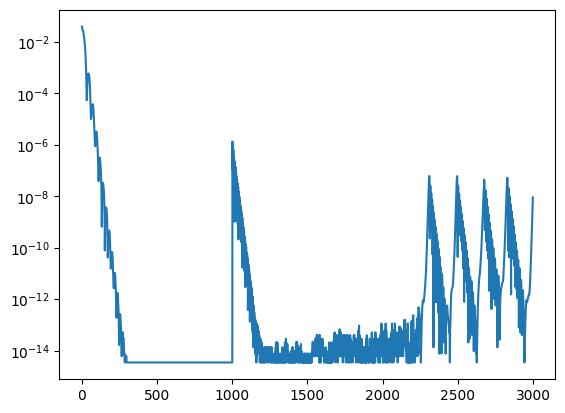

In [42]:
ax = resu['loss'].plot()
ax.set_yscale("log")

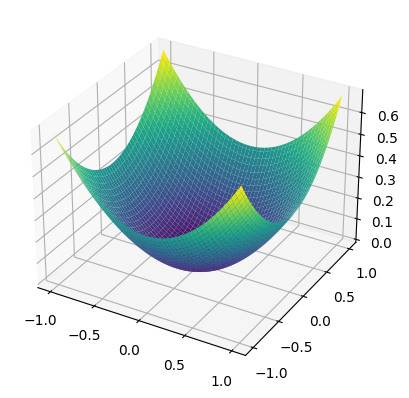

In [43]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

In [44]:
def lossFunction(x, y,  beta):
    def riccatiEquation(z):
        return z**2 - 4 * beta * z - 2 * beta
    return np.diag([riccatiEquation(x), riccatiEquation(y)])

def scalarisedLossFunction(x, y, beta=0.1):
    return np.linalg.norm( lossFunction(x, y, beta) )

In [45]:
x = np.linspace(-0.6, 1, 100)
y = np.linspace(-0.6, 1, 100)

X, Y = np.meshgrid(x, y)
vectorisedScalarisedLossFunction = np.vectorize(scalarisedLossFunction)
Zresidual = vectorisedScalarisedLossFunction(X, Y)

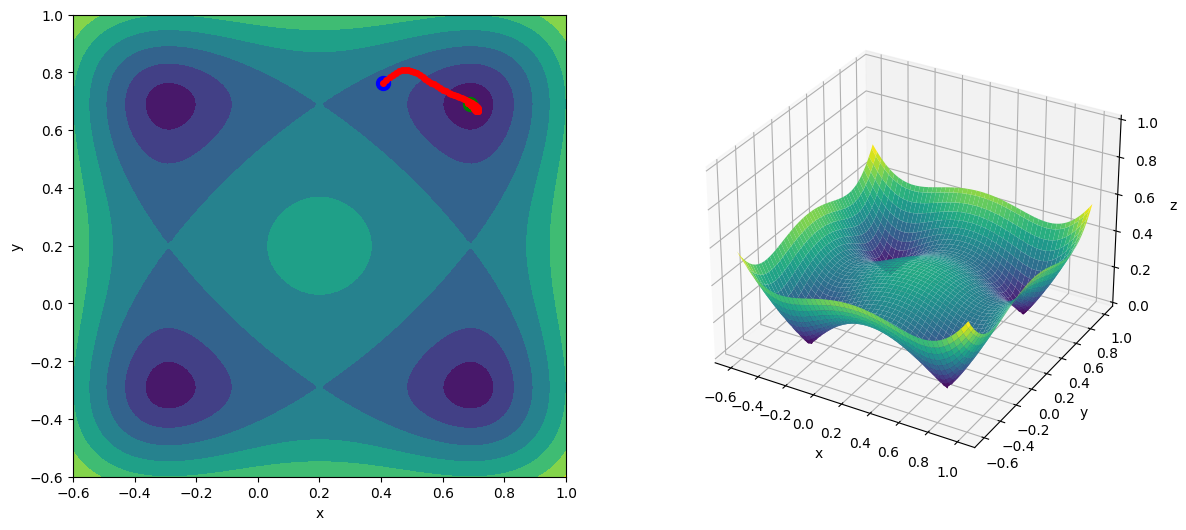

In [46]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 2, 1)
ax.contourf(X, Y, Zresidual)

# Extract x and y coordinates
w1 = [weights[0] for weights in resu['weights']]
w2 = [weights[1] for weights in resu['weights']]

# Plotting the gradient descent path
ax.plot(w1, w2, 'r-o', markersize=4, label='Gradient Descent Path')
ax.scatter(w1[0], w2[0], color='blue', label='Start', s=100)  # Start point
ax.scatter(w1[-1], w2[-1], color='green', label='End', s=100)  # End point
ax.set_xlabel('x')
ax.set_ylabel('y');

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Zresidual, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(0,1);